In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd


from helpers import generate_embedding, combined_embeddings
from graph_role_extraction import find_k_clusters, find_optimal_clusters, HellingerPCs

# Data

The below code requires the Florida bay network data obtained from the Pajek network repository also available at $\href{https://networkrepository.com/foodweb-baydry.php}{https://networkrepository.com/foodweb-baydry.php}$.

The metadata is included in the code.

In [2]:
with open("Florida bay/baydry.paj") as f:
    lines = f.readlines() 

In [3]:
G_ = nx.parse_pajek(lines)
mapping = dict(zip(list(G_.nodes()) ,np.arange(len(G_.nodes))))
mapping2 = dict(zip(np.arange(len(G_.nodes)), list(G_.nodes())))
G = nx.DiGraph()
removals = ['Water POC', 'Benthic POC', 'DOC', 'Input', 'Output', 'Respiration']
for i in range(len(G_.nodes)):
    if mapping2[i] in removals:
        continue
    G.add_node(i,
               name = mapping2[i])

for i,j,k in G_.edges(data=True):
    if len(k)==0 or i in removals or j in removals:
        continue
    G.add_edge(mapping[i], mapping[j], weight=k['weight'])

G.remove_nodes_from([u for u in nx.isolates(G)])
#G.remove_nodes_from()

in_w = dict(G.in_degree(weight='weight'))           # {node: weighted_in_degree}
rescaling = {n: (1.0/deg if deg != 0 else np.inf)
             for n, deg in in_w.items()}

for u, v, data in G.edges(data=True):
    if rescaling[v] != np.inf:                      # skip nodes with zero in-degree
        data['weight'] *= rescaling[v]


G= nx.convert_node_labels_to_integers(G, first_label=0)
N = len(G.nodes)

In [101]:
def process(line):
    processed = line.strip().split(';')
    output = []
    for i in range(len(processed)):
        output.append(processed[i].strip())
    return output

line1 = 'um Spherical Phytoplankton ; Synnedococcus ; Oscillatoria ; Small Diatoms ; Big Diatoms ; Dinoflagellates ; Other Phytoplankton ; Benthic Microalgae; Thalassia testudinum ; Halodule wrightii ; Syringodium filiforme ; Roots ; Drift Algae ; Epiphytes'
line2 = 'Free Bacteria ; Water-Column Flagellates ; Water-Column Cilliates ; Acartia tonsa ; Oithona nana ; Paracalanus sp. ; Other Copepods ; Meroplankton ; Other Zooplankton ; Benthic Flagellates ; Benthic Cilliates ; Meiofauna'
line3 = 'Sponges ; Coral ; Other Cnidaria ; Echinodermata ; Bivalves ; Detritivorous Gastropods ; Epiphyte Grazing Gastropods ; Predatory Gastropods ; Detritivorous Polychaetes ; Predatory Polychaetes ; Pelagic Feeding Polychaetes ; Macrobenthos ; Benthic Crustaceans ; Detrivorous Amphipods ; Herbivorous Amphipods ; Isopods ; Herbivorous Shrimp ; Predaceous Shrimp ; Pink Shrimp ; Thor floridanus ; Spiny Lobster ; Detritivorous Crabs ; Omnivorous Crabs ; Predatory Crabs ; Callinectes spp. ; Stone Crab'
line4 = 'Sharks ; Rays ; Tarpon and Ladyfish ; Bonefish ; Sardines ; Anchovies ; Bay Anchovy ; Lizardfish ; Catfishes ; Eels ; Toadfish ; Brotulas and Batfishes ; Halfbeaks and Flyingfish ; Needlefishes ; Killifishes ; Floridychthys carpio ; Lucania parva ; Snooks ; Poecilids ; Silversides ; Seahorses and Pipefishes ; Sygnathus scovelli ; Hippocampus zosterae ; Groupers ; Jacks and Runners ; Pompano and Permits ; Snappers ; Gray Snapper ; Mojarras and Jennies ; Grunts ; Porgies ; Pinfish ; Sciaenid fishes ; Spotted Seatrout ; Red Drum ; Spadefish ; Parrotfishes ; Mackerels ; Mullets ; Barracudas ; Blennies ; Code Goby ; Clown Goby ; Flatfishes ; Filefishes and Trigger fishes ; Puffers and Burrfishes ; Other Pelagics ; Other Demersals'
line5 = 'American Crocodile ; Loggerhead Turtle ; Green Turtle ; Hawksbill Turtle'
line6 = 'Loons ; Grebes ; Pelicans ; Cormorants ; Big Herons and Egrets ; Small Herons and Egrets ; Ibis ; Roseate Spoonbill ; Herbivorous Ducks ; Omnivorous Ducks ; Predaceous Ducks ; Raptors ; Gruiformes ; Small Shorebirdss ; Gulls and Terns ; Kingfishers'
line7 = 'Dolphins ; Manatee'

primary_producers = process(line1)
microfauna = process(line2)
macroinvert = process(line3)
fishes = process(line4)
herpetofauna  = process(line5)
avifauna = process(line6)
mammals = process(line7)

for i in range(len(G.nodes)):
    if G.nodes('name')[i] in primary_producers:
        G.nodes[i]['group'] = 'Primary Producer'
    elif G.nodes('name')[i] in microfauna:
        G.nodes[i]['group'] = 'Microfauna'
    elif G.nodes('name')[i] in macroinvert:
        G.nodes[i]['group'] = 'Macroinvertebraes'
    elif G.nodes('name')[i] in fishes:
        G.nodes[i]['group'] = 'Fishes'
    elif G.nodes('name')[i] in herpetofauna:
        G.nodes[i]['group'] = 'Herpetofauna'
    elif G.nodes('name')[i] in avifauna:
        G.nodes[i]['group'] = 'Avifauna'
    elif G.nodes('name')[i] in mammals:
        G.nodes[i]['group'] = 'Mammals'
    else:
        if i<=10:
            G.nodes[i]['group'] = 'Primary Producer'
        elif i<=23:
            G.nodes[i]['group'] = 'Microfauna'
        elif i<=49:
            G.nodes[i]['group'] = 'Macroinvertebraes'
        elif i<=98:
            G.nodes[i]['group'] = 'Fishes'
        elif i<=114:
            G.nodes[i]['group'] = 'Avifauna'
        elif i<=115:
            G.nodes[i]['group'] = 'Herpetofauna'
        elif i<=119:
            G.nodes[i]['group'] = 'Mammals'
        else:
            print(i)




In [31]:
A = nx.to_scipy_sparse_array(G)
embedding = combined_embeddings(A, M=100, alpha=0.1, normalise_embedding=True)
pca = HellingerPCs(embedding, n_components=15)

/opt/anaconda3/lib/python3.12/site-packages/scipy/sparse/_base.py:730: RuntimeWarning: divide by zero encountered in divide
  recip = np.true_divide(1., other)


In [81]:
clusters, roles, group_to_nodes, n_clusters, df = find_optimal_clusters(HellingerPC = pca[:,:3], max_clusters=10, method='gmm')
clusters, roles, group_to_nodes = find_k_clusters(HellingerPC = pca[:,:10], n_clusters=2)

Text(0, 0.5, 'BIC')

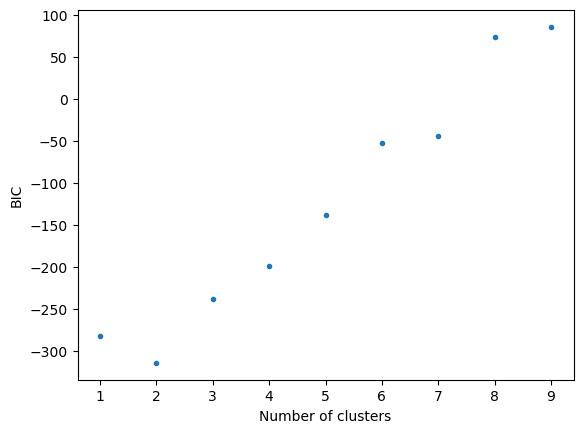

In [83]:
plt.plot(np.arange(1, len(df)+1), df['BIC score'], '.')
plt.xlabel('Number of clusters') ; plt.ylabel('BIC')

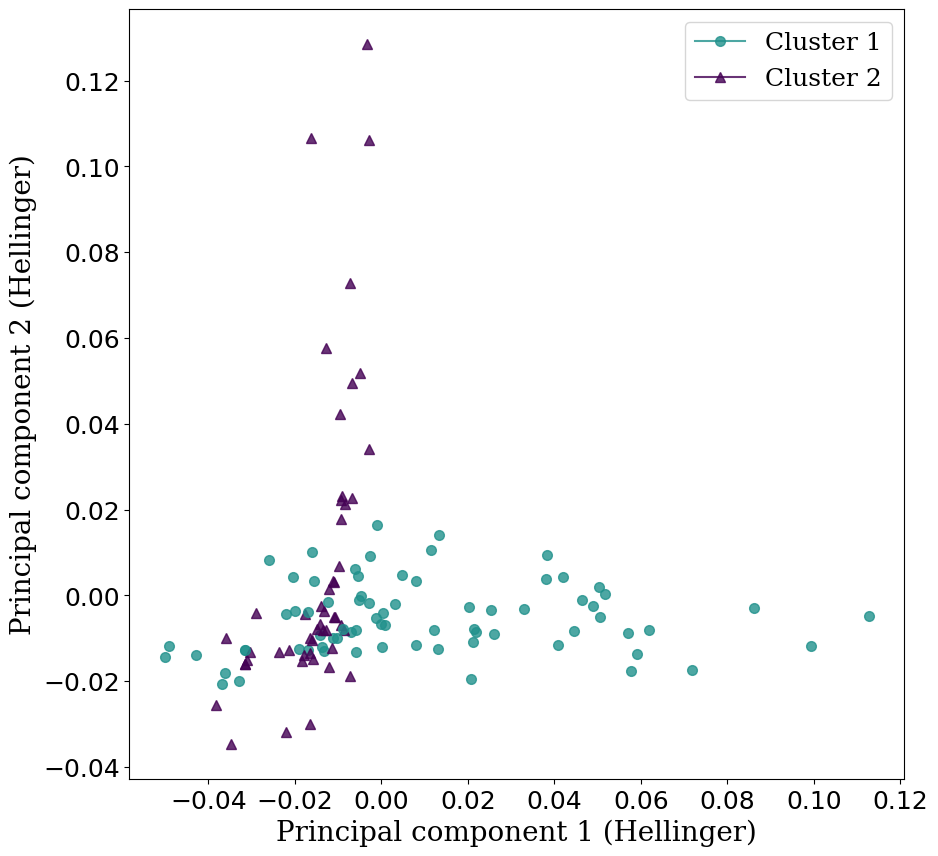

In [99]:
fig = plt.figure(figsize=(10, 10))
# Generate colors for each community
uniqs = np.unique(clusters)
colors = [plt.cm.viridis(i / len(uniqs)) for i in range(len(uniqs))]
#colors = ['cyan', 'b', 'red', 'purple', 'green', 'orange', 'gray']
#colors = ['cyan', 'purple',  'orange', 'red', 'b', 'green', 'gray']
node_colors = [colors[roles[node]] for node in G.nodes()]

for i in range(N):
    if roles[i] == 0:
        plt.plot(pca[i, 0], pca[i, 1], color=node_colors[i], marker='^', markersize=7, alpha=0.8)
    elif roles[i] == 1:
        plt.plot(pca[i, 0], pca[i, 1], color=node_colors[i], marker='o', markersize=7, alpha=0.8)

plt.plot(pca[0, 0], pca[0, 1], color=node_colors[0], marker='o', markersize=7, alpha=0.8, label='Cluster 1')
plt.plot(pca[31, 0], pca[31, 1], color=node_colors[31], marker='^', markersize=7, alpha=0.8, label='Cluster 2')

#plt.legend()
#plt.title('PCA')
plt.xlabel('Principal component 1 (Hellinger)', fontsize=20, font='serif') 
plt.ylabel('Principal component 2 (Hellinger)', fontsize=20, font='serif')

plt.xticks(fontsize=18) ; plt.yticks(fontsize=18)
plt.legend(prop={'family':'serif', 'size':18})

plt.savefig('Florida clusters PC.pdf', bbox_inches='tight')

In [103]:
labels = [G.nodes(data=True)[i]['group'] for i in G.nodes()]

In [105]:
unique_labels = np.unique(labels)

colors = [plt.cm.jet(i / len(unique_labels)) for i in range(len(unique_labels))] 
#colors = ['r', 'r', 'b', 'r', 'y', 'r', 'b', 'r']
class_colors = []
for i in tqdm(range(N)):
    for j in range(len(unique_labels)):
        try:
            if np.isnan(labels[i]):
                class_colors.append(colors[-1])
        except:
            if labels[i] == unique_labels[j]:
                class_colors.append(colors[j])

100%|██████████████████████████████████████| 121/121 [00:00<00:00, 81935.87it/s]


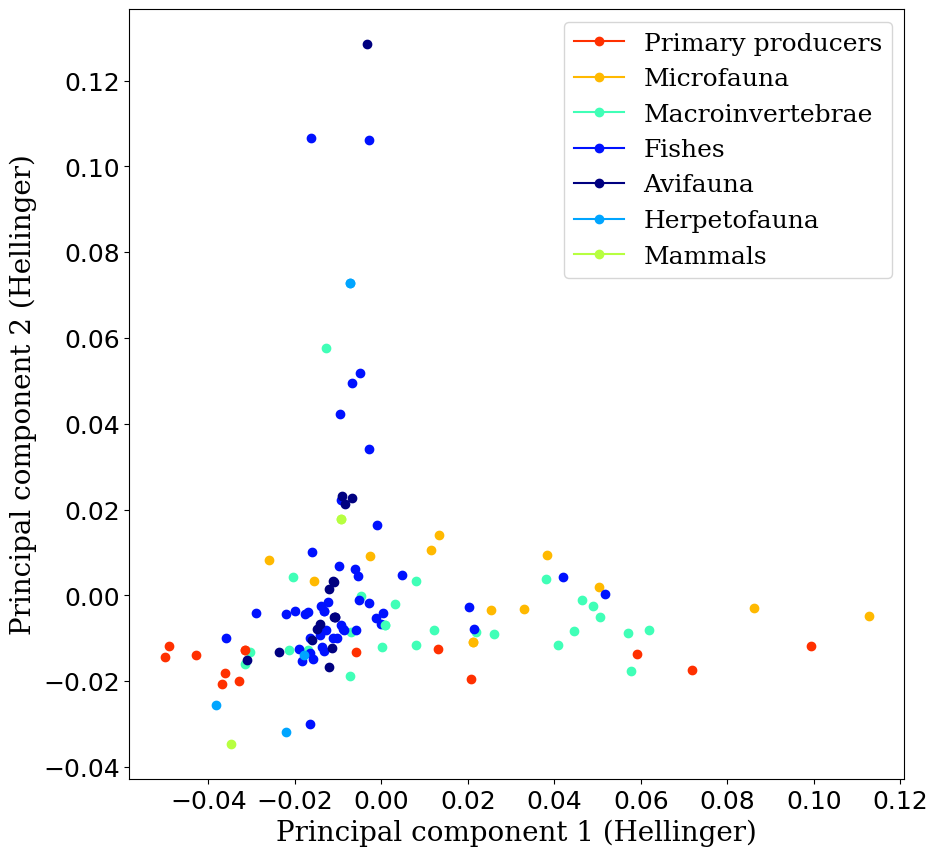

In [111]:
fig = plt.figure(figsize=(10, 10))
for i in range(N):
    plt.plot(pca[i, 0], pca[i, 1], marker='o', color=class_colors[i])

plt.plot(pca[0, 0], pca[0, 1], marker='o', color=class_colors[0], label='Primary producers')
plt.plot(pca[13, 0], pca[13, 1], marker='o', color=class_colors[13], label='Microfauna')
plt.plot(pca[25, 0], pca[25, 1], marker='o', color=class_colors[25], label='Macroinvertebrae')
plt.plot(pca[51, 0], pca[51, 1], marker='o', color=class_colors[51], label='Fishes')
plt.plot(pca[99, 0], pca[99, 1], marker='o', color=class_colors[99], label='Avifauna')
plt.plot(pca[115, 0], pca[115, 1], marker='o', color=class_colors[115], label='Herpetofauna')
plt.plot(pca[119, 0], pca[119, 1], marker='o', color=class_colors[119], label='Mammals')

plt.legend()

plt.xlabel('Principal component 1 (Hellinger)', fontsize=20, font='serif') 
plt.ylabel('Principal component 2 (Hellinger)', fontsize=20, font='serif')

plt.xticks(fontsize=18) ; plt.yticks(fontsize=18)
plt.legend(prop={'family':'serif', 'size':18})

plt.savefig('Florida ground truth.pdf', bbox_inches='tight')

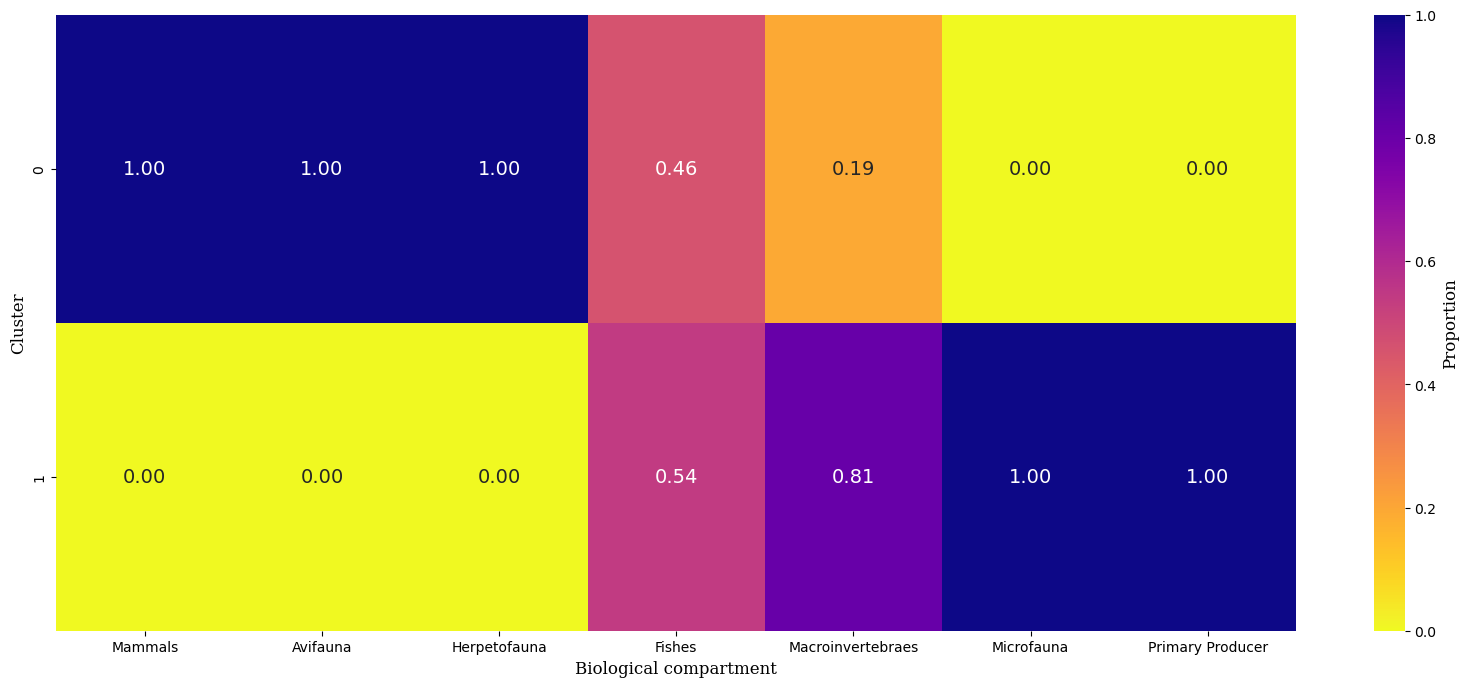

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({'Cluster': clusters, 'Label': labels})
# Cross-tab (normalize however you like: by column, by row, or absolute counts)
ct = pd.crosstab(df['Cluster'], df['Label'], normalize='columns')

new_order = ['Mammals', 'Avifauna', 'Herpetofauna', 'Fishes', 'Macroinvertebraes', 'Microfauna', 'Primary Producer']    # replace with your order
ct = ct[new_order] 


plt.figure(figsize=(20,8))
ax = sns.heatmap(ct, annot=True, fmt=".2f", cmap="plasma_r",
            cbar_kws={'label': 'Proportion'},  annot_kws={"size": 14} )
cbar = ax.collections[0].colorbar

# Change the colorbar label font and size
cbar.ax.set_ylabel('Proportion', fontsize=12, fontname='serif')
plt.xlabel("Biological compartment", fontsize=12, font='serif')
plt.ylabel("Cluster", fontsize=12, font='serif')
#plt.title("Label vs. Cluster – normalized by column")
#plt.yticks(ticks=[0.5, 1.5], labels=[2, 1], font='serif', fontsize=12)
#plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], labels=unique_labels, font='serif')
#plt.tight_layout()
plt.show()